# Lab 8: Exploring Self-Attention with Amazon Mobile Reviews

## Objectives
This lab introduces students to the fundamentals of self-attention mechanisms in natural language processing through hands-on implementation. Students will work with a reviews dataset to learn essential text preprocessing techniques, create word embeddings, and build a self-attention system from scratch by implementing query, key, and value matrices along with scaled dot-product attention. Through visualization and analysis of attention patterns, students will gain insights into word relationships and model behavior. The lab culminates in practical applications comparing traditional embedding approaches with self-attention for tasks like sentence embedding generation and classification, providing a comprehensive understanding of modern NLP techniques.

## Dataset Description
We'll be using the Amazon Mobile Reviews dataset:
	customer_id	product_title	star_rating	review_body	product_id	star_rating_label

- **customer_id**: Customer Id
- **product_title**: Product name
- **star_rating**: Rating given (1-5 stars)
- **review_body**: Brief summary of the review
- **product_id**: Product ID
- **star_rating_label**: Label of rating `postive` or `negative`

## Tasks Overview
1. Data Preprocessing and Exploration
   - Load and clean the reviews dataset
   - Implement basic text preprocessing
   - Create vocabulary and word embeddings

2. Self-Attention Implementation
   - Build query, key, and value matrices
   - Implement scaled dot-product attention
   - Create positional encodings

3. Analysis and Visualization
   - Visualize attention patterns
   - Analyze word relationships
   - Interpret model behavior

4. Applications
   - Sentence embedding generation
   - Classification with normal embedding vs. self attention

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
# from transformers import BertForSequenceClassification
from transformers import AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import numpy as np
from transformers import BertTokenizer, BertModel, AdamW
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch.nn.functional as F

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### simple self attention example with one sentence.

In [100]:
sentence = 'The quick brown fox jumps over a lazy dog'
dc = {s: i for i, s in enumerate(sorted(sentence.replace(',', '').split()))}
print(dc)

{'The': 0, 'a': 1, 'brown': 2, 'dog': 3, 'fox': 4, 'jumps': 5, 'lazy': 6, 'over': 7, 'quick': 8}


In [101]:
r = [dc[i] for i in sentence.replace(',', '').split()]
sentence_int = torch.tensor(r)
print(sentence_int)

tensor([0, 8, 2, 4, 5, 7, 1, 6, 3])


In [102]:
vocab_size = 50000  # Assume a large vocabulary size

torch.manual_seed(123)
embed = nn.Embedding(vocab_size, 3)
embedded_sentence = embed(sentence_int).detach()

print(embedded_sentence)
# print(embedded_sentence)

tensor([[ 0.3374, -0.1778, -0.3035],
        [ 0.4965, -1.5723,  0.9666],
        [-0.2196, -0.3792,  0.7671],
        [ 0.1794,  1.8951,  0.4954],
        [ 0.2692, -0.0770, -1.0205],
        [ 1.3010,  1.2753, -0.2010],
        [-0.5880,  0.3486,  0.6603],
        [-0.1690,  0.9178,  1.5810],
        [-1.1925,  0.6984, -1.4097]])


### Self-Attention
Self-attention is computed using three main components:
- Query (Q): What we're looking for
- Key (K): What we're comparing against
- Value (V): What we're aggregating

The attention weights are computed as: 
$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$

![Screenshot 2025-01-02 120754.png](<attachment:Screenshot 2025-01-02 120754.png>) 

![Screenshot 2025-01-02 120947.png](<attachment:Screenshot 2025-01-02 120947.png>)
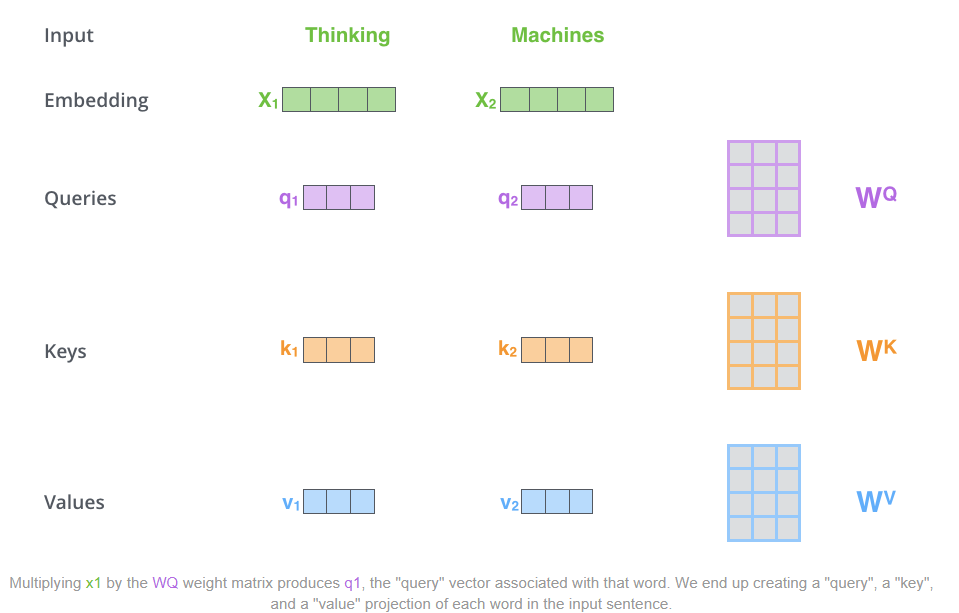
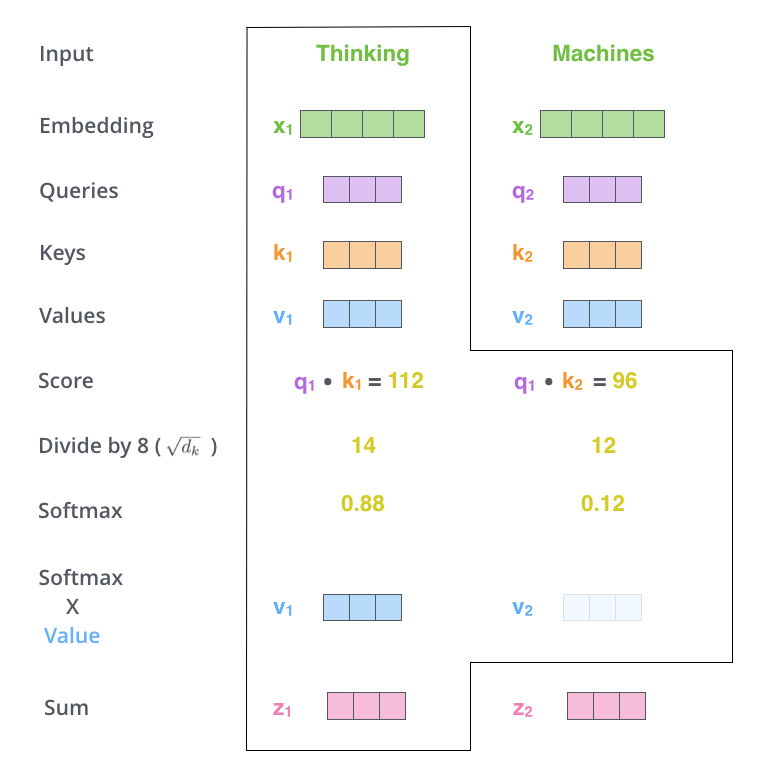

- query: torch.Tensor (batch_size, num_heads, seq_len, d_k)
- key: torch.Tensor (batch_size, num_heads, seq_len, d_k)
- value: torch.Tensor (batch_size, num_heads, seq_len, d_v)
- mask: Optional mask to prevent attention to certain positions

In [103]:
torch.manual_seed(123)
d = embedded_sentence.shape[1]  # Dimension of embeddings
d_q, d_k, d_v = 2, 2, 4  # Dimensions for query, key, and value matrices

In [104]:
W_query = torch.nn.Parameter(torch.rand(d, d_q))
W_key = torch.nn.Parameter(torch.rand(d, d_k))
W_value = torch.nn.Parameter(torch.rand(d, d_v))


query = embedded_sentence @ W_query
key = embedded_sentence @ W_key
value = embedded_sentence @ W_value

In [105]:
attention_scores = query @ key.T
attention_scores = attention_scores / math.sqrt(d_k)
attention_weights = F.softmax(attention_scores, dim=-1)

In [106]:
context_vector = attention_weights @ value
print(context_vector)

tensor([[ 0.1161,  0.2648,  0.1661,  0.2705],
        [ 0.1610,  0.3502,  0.2213,  0.3606],
        [ 0.2796,  0.5341,  0.3544,  0.5734],
        [ 0.8153,  1.4165,  0.9633,  1.5575],
        [-0.0840, -0.0267, -0.0515, -0.0758],
        [ 0.7347,  1.2733,  0.8703,  1.4049],
        [ 0.3734,  0.6840,  0.4609,  0.7442],
        [ 0.8109,  1.4172,  0.9614,  1.5550],
        [-0.2663, -0.2382, -0.2310, -0.3559]], grad_fn=<MmBackward0>)


### Implementation of self attention

In [107]:
class SelfAttention(nn.Module):
    def __init__(self, d, d_q, d_k, d_v):
        super(SelfAttention, self).__init__()
        self.d = d
        self.d_q = d_q
        self.d_k = d_k
        self.d_v = d_v
        
        self.W_query = nn.Parameter(torch.rand(d, d_q))
        self.W_key = nn.Parameter(torch.rand(d, d_k))
        self.W_value = nn.Parameter(torch.rand(d, d_v))
        
            
    def forward(self, x):
        Q = x @ self.W_query
        K = x @ self.W_key
        V = x @ self.W_value
        attention_scores = Q @ K.T / math.sqrt(self.d_k)
        attention_weights = F.softmax(attention_scores, dim=-1)
        context_vector = attention_weights @ V
        return context_vector, attention_weights

In [108]:
sa = SelfAttention(d=3, d_q=2, d_k=2, d_v=4)
cv, aw = sa(embedded_sentence)
print(cv.shape)
print(cv)

print("==================")
print(aw.shape)
print(aw)

torch.Size([9, 4])
tensor([[ 0.1298,  0.0803,  0.1391,  0.2768],
        [ 0.1655,  0.1568,  0.1631,  0.2725],
        [ 0.3061,  0.2906,  0.3173,  0.5926],
        [ 0.7892,  0.7268,  0.8756,  1.8529],
        [-0.1215, -0.2569, -0.1180, -0.1904],
        [ 0.7618,  0.7043,  0.8472,  1.7998],
        [ 0.4224,  0.3984,  0.4465,  0.8663],
        [ 0.7982,  0.7307,  0.8705,  1.7889],
        [-0.3056, -0.5724, -0.3023, -0.5099]], grad_fn=<MmBackward0>)
torch.Size([9, 9])
tensor([[0.1176, 0.1104, 0.1113, 0.0900, 0.1291, 0.0910, 0.1106, 0.0887, 0.1513],
        [0.1116, 0.1574, 0.1350, 0.0792, 0.1052, 0.0732, 0.1219, 0.1089, 0.1077],
        [0.0997, 0.1233, 0.1154, 0.1270, 0.0858, 0.1216, 0.1120, 0.1456, 0.0696],
        [0.0098, 0.0083, 0.0111, 0.3624, 0.0043, 0.3924, 0.0150, 0.1959, 0.0008],
        [0.1153, 0.0939, 0.0944, 0.0353, 0.1688, 0.0364, 0.0906, 0.0351, 0.3302],
        [0.0158, 0.0115, 0.0158, 0.3523, 0.0083, 0.3917, 0.0213, 0.1811, 0.0021],
        [0.0849, 0.0966, 0.0960,

### Visulization of self attention matrix

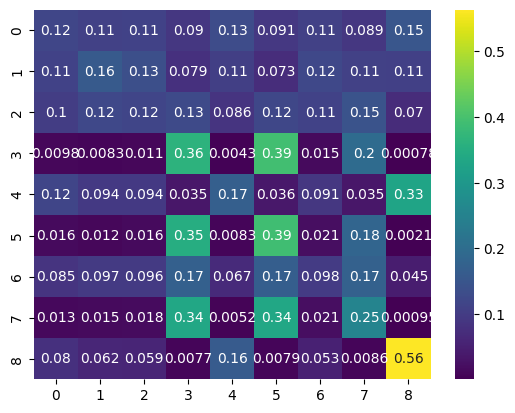

In [109]:
sns.heatmap(aw.detach().numpy(), annot=True, cmap='viridis')
plt.show()

### Implementing self attention on csv data

In [111]:
df = pd.read_csv(r"D:\Nokia_DL_L3_lab\NLP\amazon_phone_review_train.csv")

In [112]:
df.head(1)

,customer_id,product_title,star_rating,review_body,product_id,star_rating_label
0,28471074,Sprint Universal Folding Portable Mini Stereo ...,5,Item was as discribed ; was shipped fast and f...,B005BHGZ6A,positive


Sample Reviews:
   customer_id                                        review_body
0     28471074  Item was as discribed ; was shipped fast and f...
1      1958232                   Came in perfect. Works perfectly
2     49126521  Good quality, came with out the extra boom mic...
3     46531276  I do not like reading my Kindle in a case so t...
4      4487344  The case came 3 days after I ordered it. It fi...

Dataset Statistics:
Total number of reviews: 68904
Average review length: 246.77 characters


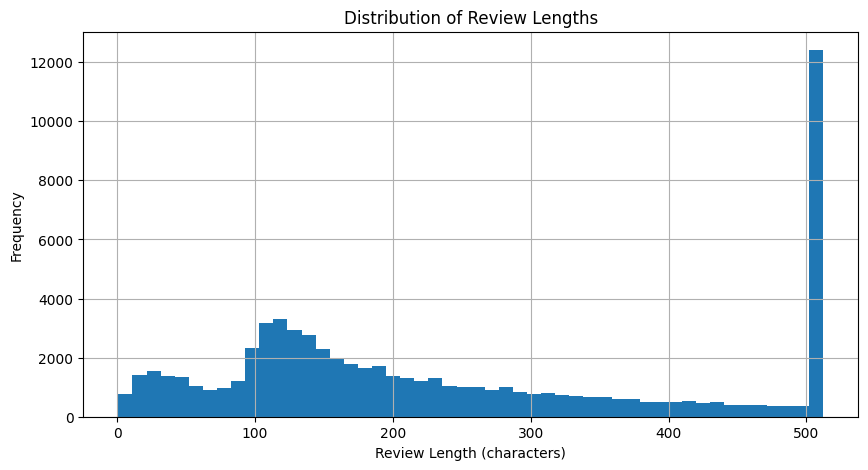

In [113]:

# Display first few reviews
print("Sample Reviews:")
print(df[['customer_id', 'review_body']].head())

# Basic statistics
print("\nDataset Statistics:")
print(f"Total number of reviews: {len(df)}")
print(f"Average review length: {df['review_body'].str.len().mean():.2f} characters")

# Review length distribution
plt.figure(figsize=(10, 5))
df['review_body'].str.len().hist(bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [114]:
def process_reviews(csv_path, num_samples=100, max_length=128):
    
    ### We are using first 100n records for this example for fast processing
    # Load BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Load CSV with limited samples
    df = pd.read_csv(csv_path)
    reviews = df['review_body'].fillna('').head(num_samples)  # Take only first num_samples
    
    # Tokenize and encode reviews
    encoded_reviews = tokenizer(
        reviews.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Get input IDs and attention mask
    input_ids = encoded_reviews['input_ids']
    attention_mask = encoded_reviews['attention_mask']
    
    # Get vocabulary tokens for visualization
    tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in input_ids]
    
    # Create embeddings using BERT
    bert = BertModel.from_pretrained('bert-base-uncased')
    with torch.no_grad():
        outputs = bert(input_ids, attention_mask)
        embeddings = outputs.last_hidden_state
        
        # Take mean over sequence length to get one vector per review
        embeddings = embeddings.mean(dim=1)  # Shape: (num_samples, 768)
    
    return embeddings, tokens

In [115]:

# Example usage
csv_path =  r'D:\Nokia_DL_L3_lab\NLP\amazon_phone_review_test.csv'
embeddings, tokens = process_reviews(csv_path)

In [116]:
# Initialize and use model
d = embeddings.shape[-1]  # BERT hidden size (768)
model = SelfAttention(d=d, d_q=64, d_k=64, d_v=64)
context_vectors, attention_weights = model(embeddings)

In [119]:
context_vectors.shape, attention_weights.shape

(torch.Size([100, 64]), torch.Size([100, 100]))

In [120]:
context_vectors[0]

tensor([ -4.3565,  -6.9448,  -4.0707,  -4.7893,  -8.0451,  -9.4607,  -0.9234,
         -2.7012,  -4.1055,  -5.5420, -10.7167,  -3.9012,  -5.1088,  -5.1238,
         -5.7119,  -5.6838,  -4.7091,  -2.9482,  -5.9258,  -3.3943,  -4.6159,
         -6.6172, -12.6946,  -4.5418,  -6.1143,  -7.2236,  -4.6142,  -9.2352,
         -4.1855,  -7.9176, -10.2189,  -4.6862,  -4.3371,  -7.4712,  -8.2053,
         -7.2121,  -8.3378,  -4.5686,  -5.3153,  -3.4942,  -2.9625,  -3.7391,
         -5.9130,  -7.1320,  -5.7081,  -4.7216,  -4.6319,  -3.9147,  -5.3876,
         -6.0355,  -5.3708,  -6.1909,  -7.5208,  -4.8170,  -6.2186,  -9.7723,
         -3.1231,  -3.7220,  -2.6192,  -7.6178,  -6.9219,  -9.0284,  -5.4576,
         -2.9130], grad_fn=<SelectBackward0>)

<Axes: >

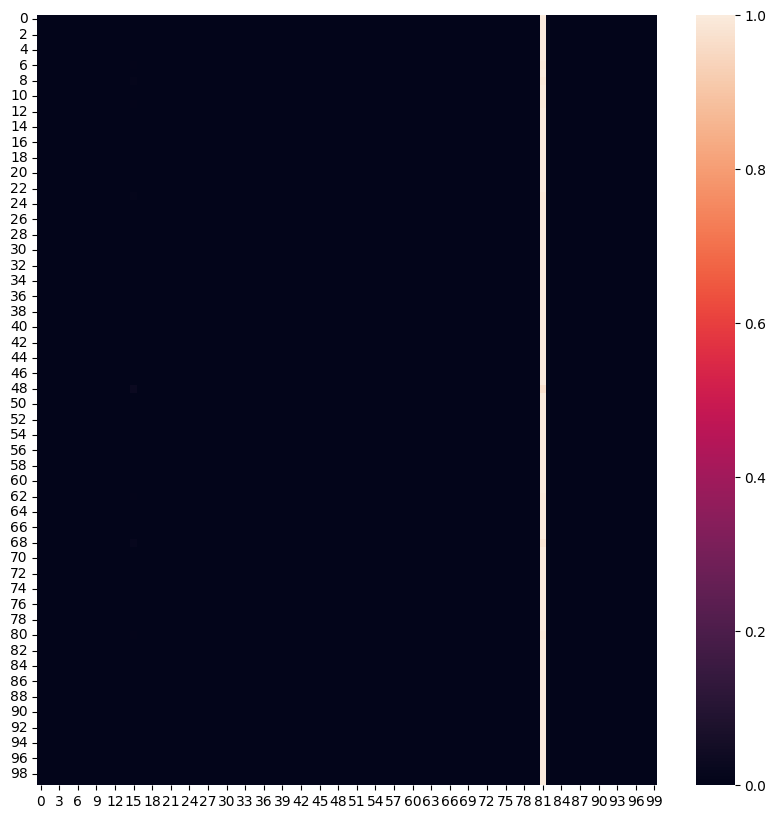

In [121]:
plt.figure(figsize=(10,10))
sns.heatmap(attention_weights.detach().numpy())

### Classification with normal embedding vs. self-attention 

In [165]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from collections import Counter


### Simple vocabulary and tokenizer

In [166]:
# Simple Vocabulary and Tokenizer
class SimpleVocabulary:
    def __init__(self, texts, max_vocab_size=10000):
        # Add special tokens
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        
        # Count words and create vocabulary
        word_counts = Counter()
        for text in texts:
            words = text.lower().split()
            word_counts.update(words)
        
        # Add most common words to vocabulary
        for word, _ in word_counts.most_common(max_vocab_size - 2):
            if word not in self.word2idx:
                self.word2idx[word] = len(self.word2idx)
        
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
    
    def encode(self, text, max_length=128):
        words = text.lower().split()
        ids = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]
        
        # Pad or truncate
        if len(ids) < max_length:
            ids = ids + [self.word2idx['<PAD>']] * (max_length - len(ids))
        else:
            ids = ids[:max_length]
        
        return ids

### Defining Pytroch dataset

In [142]:
# Dataset classes
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, vocabulary, max_length=128):
        self.texts = texts
        self.labels = labels
        self.vocabulary = vocabulary
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoded = self.vocabulary.encode(text, self.max_length)
        return {
            'input_ids': torch.tensor(encoded, dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


### Baseline classifier with nomral embedding and LSTM layer

In [143]:
# Baseline Model (without self-attention)
class BaselineClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])  # Take last hidden state
        return out

### Function of training loop

In [150]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, is_attention_model=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            if is_attention_model:
                outputs, _ = model(input_ids)
            else:
                outputs = model(input_ids)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)
                
                if is_attention_model:
                    outputs, _ = model(input_ids)
                else:
                    outputs = model(input_ids)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {100.*train_correct/train_total:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {100.*val_correct/val_total:.2f}%')
        print('--------------------')

### Preparing dataset

In [159]:
# Prepare data
df = pd.read_csv(r'D:\Nokia_DL_L3_lab\NLP\amazon_phone_review_train.csv')
df['label'] = (df['star_rating'] > 3).astype(int)  # Binary classification

# Clean text data
df['review_body'] = df['review_body'].fillna('').str.lower()

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review_body'].values, df['label'].values, test_size=0.2, random_state=42
)

### Preparing dataloader

In [160]:
# Create vocabulary and datasets
vocabulary = SimpleVocabulary(train_texts)
train_dataset = ReviewDataset(train_texts, train_labels, vocabulary)
val_dataset = ReviewDataset(val_texts, val_labels, vocabulary)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


### Training of base line classifier

In [161]:
# Model parameters
vocab_size = vocabulary.vocab_size
embed_dim = 128
hidden_dim = 256
num_classes = 2

# Train and evaluate baseline model
print("Training Baseline Model...")
baseline_model = BaselineClassifier(vocab_size, embed_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters())
train_model(baseline_model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Training Baseline Model...
Epoch 1:
Train Loss: 0.6412, Train Acc: 66.16%
Val Loss: 0.6396, Val Acc: 66.21%
--------------------
Epoch 2:
Train Loss: 0.6404, Train Acc: 66.16%
Val Loss: 0.6403, Val Acc: 66.21%
--------------------
Epoch 3:
Train Loss: 0.6404, Train Acc: 66.16%
Val Loss: 0.6399, Val Acc: 66.21%
--------------------
Epoch 4:
Train Loss: 0.6404, Train Acc: 66.16%
Val Loss: 0.6396, Val Acc: 66.21%
--------------------
Epoch 5:
Train Loss: 0.6403, Train Acc: 66.16%
Val Loss: 0.6396, Val Acc: 66.21%
--------------------


### Evaluation of base line model

In [162]:
# Evaluate baseline model
baseline_model.eval()
all_preds = []
all_labels = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    for batch in val_loader:
        outputs = baseline_model(batch['input_ids'].to(device))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['label'].numpy())

print("\nBaseline Model Classification Report:")
print(classification_report(all_labels, all_preds))


Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4656
           1       0.66      1.00      0.80      9125

    accuracy                           0.66     13781
   macro avg       0.33      0.50      0.40     13781
weighted avg       0.44      0.66      0.53     13781



d:\Nokia_DL_L3_lab\nokia\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Nokia_DL_L3_lab\nokia\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Nokia_DL_L3_lab\nokia\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Self attention layer

In [135]:
# Custom Self Attention Layer
class SelfAttention(nn.Module):
    def __init__(self, d, d_q, d_k, d_v):
        super(SelfAttention, self).__init__()
        self.d = d
        self.d_q = d_q
        self.d_k = d_k
        self.d_v = d_v
        
        # Define learnable weight matrices
        self.W_query = nn.Parameter(torch.rand(d, d_q))
        self.W_key = nn.Parameter(torch.rand(d, d_k))
        self.W_value = nn.Parameter(torch.rand(d, d_v))
            
    def forward(self, x):
        # Create query, key, and value matrices
        Q = x @ self.W_query
        K = x @ self.W_key
        V = x @ self.W_value
        
        # Calculate attention scores
        attention_scores = Q @ K.transpose(-2, -1) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Get context vector
        context_vector = attention_weights @ V
        return context_vector, attention_weights

### Defining self attention classifier model

In [136]:
# Model with Self Attention
class SelfAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        
        # Custom self-attention layer
        self.attention = SelfAttention(d=hidden_dim, d_q=64, d_k=64, d_v=hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        
        # Apply self-attention
        context_vector, attention_weights = self.attention(lstm_out)
        
        # Average pooling over sequence length
        pooled = torch.mean(context_vector, dim=1)
        out = self.fc(pooled)
        return out, attention_weights

### Training of self attention classifier model

In [163]:
# Train and evaluate self-attention model
print("\nTraining Self-Attention Model...")
attention_model = SelfAttentionClassifier(vocab_size, embed_dim, hidden_dim, num_classes)
optimizer = torch.optim.Adam(attention_model.parameters())
train_model(attention_model, train_loader, val_loader, criterion, optimizer, num_epochs=5, is_attention_model=True)


Training Self-Attention Model...
Epoch 1:
Train Loss: 0.5475, Train Acc: 72.96%
Val Loss: 0.4433, Val Acc: 79.16%
--------------------
Epoch 2:
Train Loss: 0.4038, Train Acc: 82.18%
Val Loss: 0.3364, Val Acc: 85.35%
--------------------
Epoch 3:
Train Loss: 0.2998, Train Acc: 87.40%
Val Loss: 0.3128, Val Acc: 86.08%
--------------------
Epoch 4:
Train Loss: 0.2531, Train Acc: 89.69%
Val Loss: 0.2925, Val Acc: 87.34%
--------------------
Epoch 5:
Train Loss: 0.2150, Train Acc: 91.51%
Val Loss: 0.3005, Val Acc: 87.28%
--------------------


### Evaluation of self attention classifier model

In [164]:
# Evaluate self-attention model
attention_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        outputs, _ = attention_model(batch['input_ids'].to(device))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['label'].numpy())

print("\nSelf-Attention Model Classification Report:")
print(classification_report(all_labels, all_preds))


Self-Attention Model Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      4656
           1       0.90      0.91      0.90      9125

    accuracy                           0.87     13781
   macro avg       0.86      0.86      0.86     13781
weighted avg       0.87      0.87      0.87     13781

